# Interferometry with coherent states using quantum Fisher information

In [7]:
%matplotlib inline

from math import *
from qutip import *
from pylab import *

from scipy.optimize import minimize as cp_minimize

import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

### Symbols & operators

In [8]:
T = sp.symbols('T')
N = 60 # dimension of the Hilbert space

# operators
I = qeye(N) # identity operator
a = destroy(N) # annihilation operator
n = num(N); n_a = tensor(n, I); n_b = tensor(I, n) # number operators
D_n = n_a - n_b # ΔN = n_1 - n_2
S_n = n_a + n_b # ΣN = n_1 + n_2
U = (1j*np.pi/4*(tensor(a.dag(), a) + tensor(a, a.dag()))).expm() # beam splitter operator

# Schwinger representation
Jx = 1/2*(tensor(a.dag(), a) + tensor(a.dag(), a))
Jy = -1j/2*(tensor(a.dag(), a) - tensor(a, a.dag()))
Jz = 1/2*(tensor(a.dag()*a, I) - tensor(I, a.dag()*a))

# Parity operator
Pa = (1j*np.pi*tensor(a.dag()*a,I)).expm()
Pb = (1j*np.pi*tensor(I,a.dag()*a)).expm()
P = (1j*np.pi*a.dag()*a).expm()

### Helper functions

In [9]:
# returns QFI (quantum Fisher information)
def qfi(rho_in):
    return np.abs(4*((rho_in*Jy**2).tr() - (rho_in*Jy).tr()**2))

#### Functions for input states

In [10]:
# returns ρ_in given pure state ψ_in
def rho_in(psi_in):
    return psi_in*psi_in.dag()

# |ψ_in_1> = |0>|α>
def psi_in_1(alpha):
    return tensor(fock(N, 0),coherent(N, alpha))

# |ψ_in_2> = |β>|β>
def psi_in_2(beta):
    return tensor(coherent(N, beta),coherent(N, beta))
    
# |ψ_in_3> = N(|γδ>+|δγ>)
def psi_in_3(gamma, delta):
    temp = tensor(coherent(N, gamma), coherent(N, delta)) + tensor(coherent(N, delta), coherent(N, gamma))
    return temp.unit()

# |ψ_in_4> = N(a_1†|α_1,α_2>+a_2†|α_1,α_2>)
def psi_in_4(alpha_1, alpha_2):
    psi_alphas = tensor(coherent(N, alpha_1),coherent(N, alpha_2)) # |α_1,α_2>
    temp = tensor(a.dag(), I)*psi_alphas + tensor(I, a.dag())*psi_alphas
    return temp.unit()
    
# |ψ_in_5> = N(a_1†²|α_1,α_2>+a_2†²|α_1,α_2>)    
def psi_in_5(alpha_1, alpha_2):
    psi_alphas = tensor(coherent(N, alpha_1), coherent(N, alpha_2)) # |α_1,α_2>
    temp = tensor(a.dag()**2, I)*psi_alphas + tensor(I, a.dag()**2)*psi_alphas
    return temp.unit()

## QFIs

### Calculating QFIs for states 1,2

In [11]:
n_1_avgs = []; qfi_1_vals = []
n_2_avgs = []; qfi_2_vals = []

alphas = [0.5*n for n in range (4,14)]
    
for alpha in alphas:
    beta = np.sqrt(alpha**2/2)

    rho_in_1 = rho_in(psi_in_1(alpha))
    rho_in_2 = rho_in(psi_in_2(beta))

    n_1_avg = np.abs((rho_in_1*S_n).tr())
    n_1_avgs.append(n_1_avg)

    n_2_avg = np.abs((rho_in_2*S_n).tr())
    n_2_avgs.append(n_2_avg)
    
    qfi_1_vals.append(1/np.sqrt(qfi(rho_in_1)))
    qfi_2_vals.append(1/np.sqrt(qfi(rho_in_2)))

### Calculating QFIs for states 3,4,5

In [12]:
def get_n_avgs_qfis(alpha_1s, alpha_2s):
    n_3_avgs = []; qfi_3_vals = []
    n_4_avgs = []; qfi_4_vals = []
    n_5_avgs = []; qfi_5_vals = []
    
    for alpha_1,alpha_2 in zip(alpha_1s,alpha_2s):
        rho_in_3 = rho_in(psi_in_3(alpha_1, alpha_2))
        rho_in_4 = rho_in(psi_in_4(alpha_1, alpha_2))
        rho_in_5 = rho_in(psi_in_5(alpha_1, alpha_2))
    
        # <n>'s
        n_3_avgs.append(np.abs((rho_in_3*S_n).tr()))
        n_4_avgs.append(np.abs((rho_in_4*S_n).tr()))
        n_5_avgs.append(np.abs((rho_in_5*S_n).tr()))
    
        # qfi's
        qfi_3_vals.append(1/np.sqrt(qfi(rho_in_3)))
        qfi_4_vals.append(1/np.sqrt(qfi(rho_in_4)))
        qfi_5_vals.append(1/np.sqrt(qfi(rho_in_5)))
        
    return [n_3_avgs, n_4_avgs, n_5_avgs], [qfi_3_vals, qfi_4_vals, qfi_5_vals]

In [14]:
alpha_1s_1 = [0.5, 1, 1, 2, 2, 3, 3, 4]
alpha_2s_1 = [0.7, 1, 2, 2, 3, 3, 4, 4]
n_avgs_1, qfi_vals_1 = get_n_avgs_qfis(alpha_1s_1, alpha_2s_1)

alpha_1s_2 = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5]
alpha_2s_2 = [-0.5, -1, -1.5, -2, -2.5, -3, -3.5, -4, -4.5]
n_avgs_2, qfi_vals_2 = get_n_avgs_qfis(alpha_1s_2, alpha_2s_2)

### Plotting QFIs vs. $\langle n \rangle$

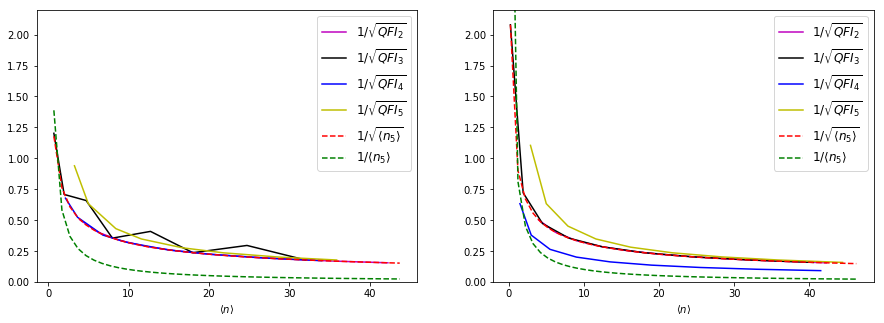

In [16]:
plt.subplot(1, 2, 1)

# QFI limits
# plt.plot(n_1_avgs, qfi_1_vals, 'c-', label=r'$1/\sqrt{QFI_1}$')
plt.plot(n_2_avgs, qfi_2_vals, 'm-', label=r'$1/\sqrt{QFI_2}$')
plt.plot(n_avgs_1[0], qfi_vals_1[0], 'k-', label=r'$1/\sqrt{QFI_3}$')
plt.plot(n_avgs_1[1], qfi_vals_1[1], 'b-', label=r'$1/\sqrt{QFI_4}$')
plt.plot(n_avgs_1[2], qfi_vals_1[2], 'y-', label=r'$1/\sqrt{QFI_5}$')

# SN & Heisenberg limits
x = arange(n_avgs_1[0][0], plt.xlim()[1])
plt.plot(x, 1/sqrt(x), 'r--', label=r'$1/\sqrt{\langle n_5 \rangle}$')
plt.plot(x, 1/array(x), 'g--', label=r'$1/\langle n_5 \rangle$')

plt.xlabel(r'$\langle n \rangle$')
plt.ylim(0,2.2)
plt.legend(loc='best', prop={'size': 12})

#---------------------------------------------------------------------------------

plt.subplot(1, 2, 2)

# QFI limits
# plt.plot(n_1_avgs, qfi_1_vals, 'c-', label=r'$1/\sqrt{QFI_1}$')
plt.plot(n_2_avgs, qfi_2_vals, 'm-', label=r'$1/\sqrt{QFI_2}$')
plt.plot(n_avgs_2[0], qfi_vals_2[0], 'k-', label=r'$1/\sqrt{QFI_3}$')
plt.plot(n_avgs_2[1], qfi_vals_2[1], 'b-', label=r'$1/\sqrt{QFI_4}$')
plt.plot(n_avgs_2[2], qfi_vals_2[2], 'y-', label=r'$1/\sqrt{QFI_5}$')

# SN & Heisenberg limits
x = arange(n_avgs_2[0][0], plt.xlim()[1])
plt.plot(x, 1/sqrt(x), 'r--', label=r'$1/\sqrt{\langle n_5 \rangle}$')
plt.plot(x, 1/array(x), 'g--', label=r'$1/\langle n_5 \rangle$')

plt.xlabel(r'$\langle n \rangle$')
plt.ylim(0,2.2)
plt.legend(loc='best', prop={'size': 12})

#---------------------------------------------------------------------------------
plt.rcParams["figure.figsize"] = [15, 5]